In [1]:
# Dependicies:
import pandas as pd
import numpy as np
from pathlib import Path
# from matplotlib.pyplot import figure

# Visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

# Import Statistics:
import scipy.stats as stats

# Import ML libiraries:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, precision_score,recall_score
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ROCAUC
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Supress Warnings
import warnings
warnings.simplefilter(action = "ignore")

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
data = Path("Resources/clean_flight_data.csv")
data_df = pd.read_csv(data)

# Review the DataFrame
data_df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,DISTANCE
0,1,3,EV,ORD,GRB,0.0,1000-1059,0.0,174.0
1,1,3,EV,TUL,ORD,0.0,1000-1059,0.0,585.0
2,1,3,EV,EWR,TYS,0.0,1800-1859,0.0,631.0
3,1,3,EV,BTR,IAH,0.0,1800-1859,0.0,253.0
4,1,3,EV,RIC,IAH,0.0,1000-1059,0.0,1157.0


#### Determine the Mean and Median Distance of delayed vs. on-time flights.

In [3]:
data_df.groupby(['DEP_DEL15'])['DISTANCE'].mean()

DEP_DEL15
0.0    796.583171
1.0    819.447567
Name: DISTANCE, dtype: float64

In [4]:
data_df.groupby(['DEP_DEL15'])['DISTANCE'].median()

DEP_DEL15
0.0    637.0
1.0    672.0
Name: DISTANCE, dtype: float64

#### Let's do a T-Test to check whether this difference is statistically significant

In [5]:
stats.ttest_ind(data_df[data_df['DEP_DEL15'] == 1]['DISTANCE'], 
                data_df[data_df['DEP_DEL15'] == 0]['DISTANCE'], equal_var = False)

TtestResult(statistic=10.20809058780734, pvalue=1.8715454711229252e-24, df=107883.42257879437)

### T-Test Brief Analysis
1) Based on the above results, the `p-value` is well higher than 0.5 and thus the null hypothesis is true. This means that there is no statistical significance in the difference of distance traveled by flights that are on time versus those that are delayed by 15 minutes or more.
2) The above test assumes that variances between the two independent samples are `not` the same. 

#### Finally dummyfying variables for categorical variables: 
* OP_UNIQUE_CARRIER
* ORIGIN 
* DEST
* DEP_TIME_BLK
* DAY_OF_MONTH
* DAY_OF_WEEK
#### and normalizing the 'DISTANCE'

In [6]:
# Create a Data Frame for dummies:
dum_df = pd.get_dummies(data_df, columns = [
                            'ORIGIN', 
                            'DEST', 
                            'OP_UNIQUE_CARRIER', 
                            'DEP_TIME_BLK', 
                            'DAY_OF_MONTH',
                            'DAY_OF_WEEK'
], dtype= 'int')

mean = dum_df['DISTANCE'].mean()
std =  dum_df['DISTANCE'].std()
dum_df['DISTANCE'] = (dum_df['DISTANCE'] - mean)  /std

dum_df.head()

,DEP_DEL15,ARR_DEL15,DISTANCE,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACT,ORIGIN_ACV,...,DAY_OF_MONTH_29,DAY_OF_MONTH_30,DAY_OF_MONTH_31,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7
0,0.0,0.0,-1.063477,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,-0.364907,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,-0.286721,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,-0.929202,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.607313,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Flight Delay ML Analysis - Prediction Models
We will implement logistics regression, decision tree, random forest, and AdaBoost classifier to predict whether a flight will be delayed. Lastly, a neural network using Keras will be used to learn about delas.:

### Baseline - Random Estimate
Let's first estimate what a completely random estimate would give us (an estimate that does not rely on data science or fancy machine learning at all) That is to say if we randomly guessed whether a flight would be late or not what our accuracy would be?

In [7]:
# Step 1: Proportion of late flights based on the sample dataset
dum_df[dum_df['ARR_DEL15'] == 1].shape[0] / dum_df.shape[0]

0.13730918387098928

So if we randomly guessed a flight would be late we'd be correct `13.7%` of the time. Conversely, if we randomly guessed a flight would not be late then we'd be correct `86.3%` of the time. Let's check whether our models beat this.


### Logistic Regression Model


In [8]:
X = dum_df.drop(['ARR_DEL15'], axis = 1)
y = dum_df['ARR_DEL15']

In [9]:
# Split metrics into random train and test subsets. 50% training and 50% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

In [10]:
# Implements regularized logistic regression solvers.
lr_model = LogisticRegression(max_iter = 1000, tol = 0.001,  verbose = 1)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, tol=0.001, verbose=1)

In [11]:
# Create a variable for train/test indices to split data in train/test sets.
cv = StratifiedKFold(n_splits = 5, shuffle = True)

In [12]:
# Create a variable to evaluate a score by cross-validation.
result = cross_val_score(lr_model, X_train, y_train, cv = cv)

In [13]:
print(f'Lower Limit: {np.min(result)}')
print(f'Mean: {np.mean(result)}')
print(f'Upper Limit: {np.max(result)}')

Lower Limit: 0.9313664959033491
Mean: 0.931866876251019
Upper Limit: 0.9323343401138051


In [14]:
# Predict a category for a set of input features.
pred = lr_model.predict(X_test)

# Returns the predicted probabilities of the input features belonging to each category.
pred_prob = lr_model.predict_proba(X_test)

In [15]:
print("Classification:\n",classification_report(y_test, pred, digits = 3))

# print the area under the curve
print(f'AUC: {roc_auc_score(y_test,pred_prob[:,1])}')

Classification:
               precision    recall  f1-score   support

         0.0      0.958     0.962     0.960    258253
         1.0      0.758     0.738     0.748     41381

    accuracy                          0.931    299634
   macro avg      0.858     0.850     0.854    299634
weighted avg      0.931     0.931     0.931    299634

AUC: 0.9003433400545804


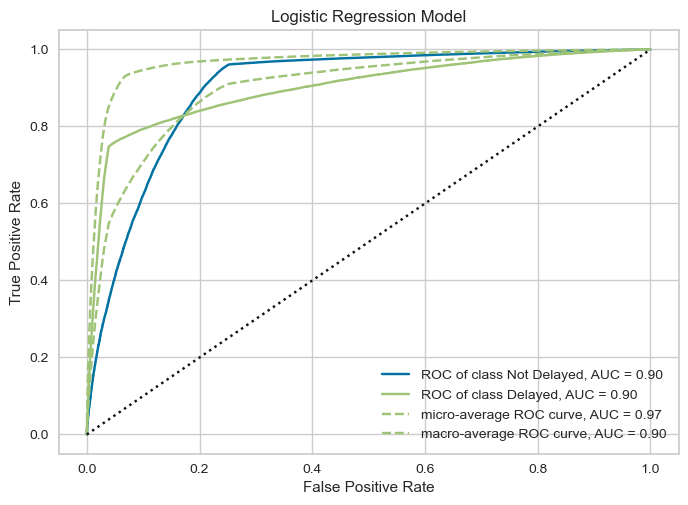

In [16]:
ax = plt.axes()
visualizer = ROCAUC(lr_model, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test)
ax.set_title('Logistic Regression Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

### Logistic Regression Model - Output Analysis
1) The AUC, which is the area under the ROC (Receiver Operating Curve) has a high value of `0.90` for this classification. This is closer to 1 and is very ideal as this indicates the ability of a binary classifier to distinguish between classes.
2) Based on the ROCAUC curve above, it is clear that the classification problem output points to a more discriminating test, with little overlap between the two.
3) Finally, based on the classification report above, the precision for the *delayed* class is a lot lower (`76%`) when compared to the *not delayed* class at `96%`. This is evident with the discriminating nature of the ROC curve with the FPR (False Positive Rate) of the *not delayed* class coming in higher than that of the *delayed* class.

## Decision Tree Classifier


In [17]:
# Create a model that predicts the value of a target variable by learning simple decision
clf_dt = DecisionTreeClassifier(random_state = 0)
dt_model = clf_dt.fit(X_train, y_train)

In [18]:
# Build a text report showing the main classification metrics.
y_pred = dt_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94    258253
         1.0       0.65      0.63      0.64     41381

    accuracy                           0.90    299634
   macro avg       0.79      0.79      0.79    299634
weighted avg       0.90      0.90      0.90    299634



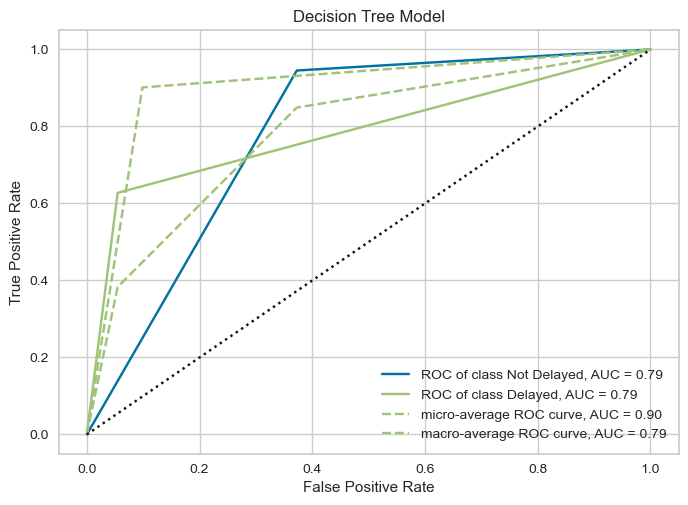

In [19]:
ax = plt.axes()
visualizer = ROCAUC(dt_model, 
                    ax = ax,
                    per_class = True,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Decision Tree Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

### Decision Tree Classifier - Output Analysis
1) The AUC, which is the area under the ROC (Receiver Operating Curve) has a much lower value of `0.79` for this classification, when compared to that of the logistic regression model. This indicates that this classification model has a lower degree of separability than that of the logistic regression model earlier.
2) Based on the classification report above, the precision for the *delayed* class is a lot lower (`65%`) when compared to the *not delayed* class at `94%`. This is evident with the discriminating nature of the ROC curve with the FPR (False Positive Rate) of the *not delayed* class coming in higher than that of the *delayed* class.
3) The Decision Tree Classifier has slightly lower precision than that of the Logistic Regression Model for the *non delayed* class but at a much lower precision for the *delayed* class. In addition, it also has a much lower AUC score indicating a higher degree of reciprocability of the results. 

## Random Forest Classifier


In [20]:
# Create a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset 
# and uses averaging to improve the predictive accuracy and control over-fitting.
clf_rf = RandomForestClassifier(n_estimators = 10)
rf_model = clf_rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [21]:
# Build a text report showing the main classification metrics.
y_pred = rf_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95    258253
         1.0       0.78      0.59      0.67     41381

    accuracy                           0.92    299634
   macro avg       0.86      0.78      0.81    299634
weighted avg       0.92      0.92      0.92    299634



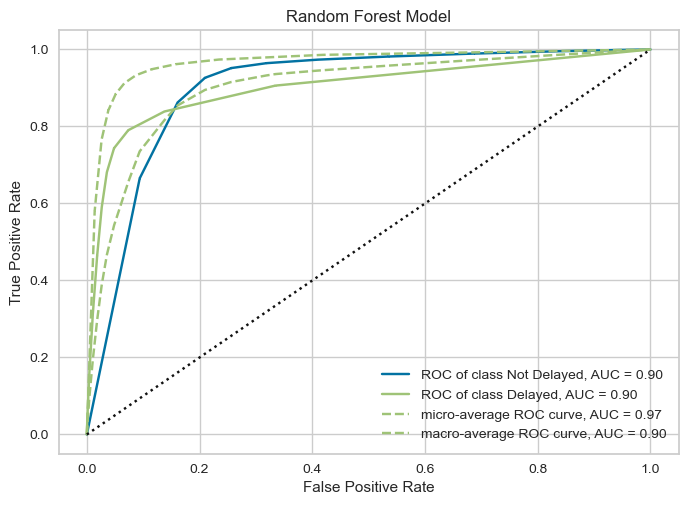

In [22]:
ax = plt.axes()
visualizer = ROCAUC(rf_model, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Random Forest Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

### Random Forest Model - Output Analysis
1) The AUC, which is the area under the ROC (Receiver Operating Curve) has a value consistent with that of a liner regression model `0.90` for this classification. This is closer to 1 and is very ideal as this indicates the ability of a binary classifier to distinguish between classes.
2) Based on the ROCAUC curve above, this model points to a more discriminating test, with little overlap between the two.
3) Finally, based on the classification report above, the precision for the *delayed* class is a lot lower (`77%`) when compared to the *not delayed* class at `94%`. This is evident with the discriminating nature of the ROC curve with the FPR (False Positive Rate) of the *not delayed* class coming in higher than that of the *delayed* class. These results closely align with that of the logistic regression model earlier.

## Ada Boost Classifier

In [23]:
# Create a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies 
# of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted 
# such that subsequent classifiers focus more on difficult cases.
Adaboost = AdaBoostClassifier()
model_adaboost = Adaboost.fit(X_train, y_train)

In [24]:
y_pred = model_adaboost.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    258253
         1.0       0.76      0.73      0.74     41381

    accuracy                           0.93    299634
   macro avg       0.86      0.84      0.85    299634
weighted avg       0.93      0.93      0.93    299634



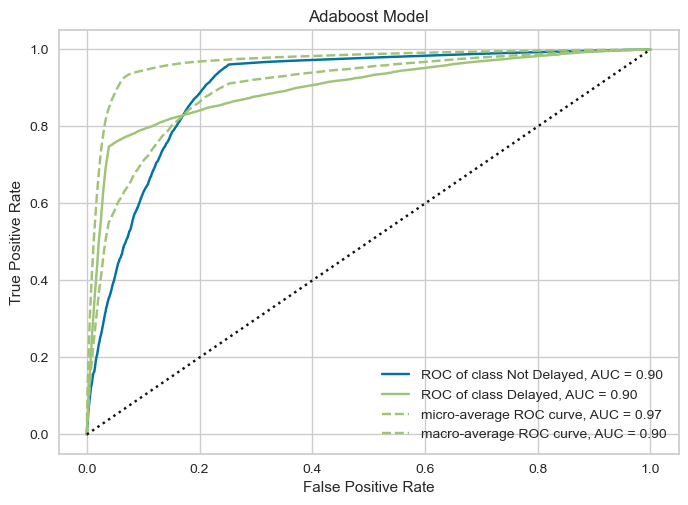

In [25]:
ax = plt.axes()
visualizer = ROCAUC(model_adaboost, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Adaboost Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

### AdaBoost Classifier Model - Output Analysis
1) The AUC, which is the area under the ROC (Receiver Operating Curve) has a value consistent with that of a liner regression model `0.90` for this classification. This is closer to 1 and is very ideal as this indicates the ability of a binary classifier to distinguish between classes.
2) Based on the ROCAUC curve above, this model points to a more discriminating test, with little overlap between the two.
3) Finally, based on the classification report above, the precision for the *delayed* class is a lot lower (`76%`) when compared to the *not delayed* class at `96%`. This is evident with the discriminating nature of the ROC curve with the FPR (False Positive Rate) of the *not delayed* class coming in higher than that of the *delayed* class. These results closely align with that of the logistic regression model earlier.

## Neural Network Model with Keras


Building a straightforward neural network since the more complicated ones did not improve our estimates:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

nn = Sequential()
nn.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
nn.add(Dense(8, input_dim = X_train.shape[1], activation = 'relu'))
nn.add(Dense(2, activation = 'softmax'))

nn.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          49,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,330 (196.60 KB)

 Trainable params: 50,330 (196.60 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_s = nn.fit(X_train, y_train, validation_split = 0.5, epochs = 30, batch_size = 128)

Epoch 1/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9036 - loss: 0.2845 - val_accuracy: 0.9325 - val_loss: 0.2109
Epoch 2/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9318 - loss: 0.2093 - val_accuracy: 0.9320 - val_loss: 0.2101
Epoch 3/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9321 - loss: 0.2083 - val_accuracy: 0.9325 - val_loss: 0.2096
Epoch 4/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9321 - loss: 0.2062 - val_accuracy: 0.9319 - val_loss: 0.2096
Epoch 5/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9323 - loss: 0.2054 - val_accuracy: 0.9321 - val_loss: 0.2081
Epoch 6/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9306 - loss: 0.2072 - val_accuracy: 0.9326 - val_loss: 0.2081
Epoch 7/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9330 - loss: 0.2035 - val_accuracy: 0.9318 - val_loss: 0.2102
Epoch 8/30
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9336 - loss: 0.2008 - 

In [28]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test, y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

9364/9364 - 7s - 715us/step - accuracy: 0.9298 - loss: 0.2224
Loss: 0.2223999798297882, Accuracy: 0.9297876954078674


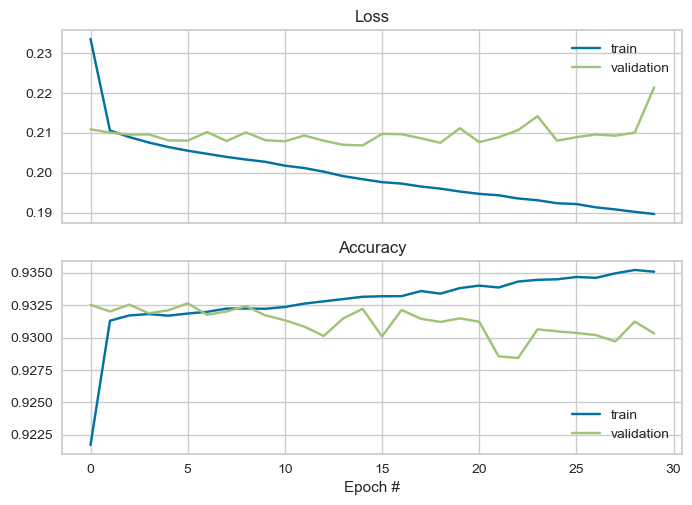

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
ax1.set_title('Loss')
ax1.plot(history_s.history['loss'], label = 'train')
ax1.plot(history_s.history['val_loss'], label = 'validation')
ax1.legend()

# plot accuracy during training
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch #')
ax2.plot(history_s.history['accuracy'], label = 'train')
ax2.plot(history_s.history['val_accuracy'], label = 'validation')
ax2.legend()
plt.show()

In [30]:
_, train_acc = nn.evaluate(X_train, y_train, verbose = 0)
_, test_acc = nn.evaluate(X_test, y_test, verbose = 0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.933, Test: 0.930


### Neural Network Model - Output Analysis
1) Based on the results above, it can be concluded that the loss function of the Neural Network (NN) Model, which is a function of the discrepancy between the predicted and targeted outputs, stabilizes around `20%` with subsequent training from the initial `25%`. The trained and validated datasets also have a high degree of accuracy around `93%` for this classifier.
2) Furthermore, based on the *loss* learning and *accuracy* learning curves of the NN model, it can be concluded that the model would not get more help with additional training as the plot of validation loss **decreases** to a point in congruence with that of the learning loss and then slightly increases again. This could be indicating an inflection point of overfitting the learning curve of this model. 
